In [1]:
from rouge_score import rouge_scorer
import os
import re
from glob import glob
import random
import jsonlines
from torch.utils.data import Dataset
from util import *
import torch
from tqdm import tqdm
from transformers import AutoTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dataset import CORWAanalysisDataset

In [3]:
def metric(scores): 
    return (scores["rouge1"][1] + scores["rouge2"][1]) / 2

In [4]:
def patch_sent_tokenize(sentences):
    out = []
    i = 0
    while i < len(sentences):
        if i>0 and sentences[i-1][-4:] == " et." and sentences[i][:2] == "al":
            out[-1] += " " + sentences[i]
        elif i>0 and (sentences[i-1][-4:] == " al." or sentences[i-1]=="al."):
            out[-1] += " " + sentences[i]
        elif i>0 and sentences[i-1][-4:] == "e.g.":
            out[-1] += " " + sentences[i]
        elif i>0 and sentences[i-1][-4:] == "i.e.":
            out[-1] += " " + sentences[i]
        elif i>0 and sentences[i-1][-4:] == "Ref.":
            out[-1] += " " + sentences[i]
        elif i>0 and sentences[i-1][-3:] == "Eq.":
            out[-1] += " " + sentences[i]
        elif i>0 and sentences[i-1][-4:] == "Sec.":
            out[-1] += " " + sentences[i]
        else:
            out.append(sentences[i])
        i += 1
    return out

In [5]:
def retrieve_sentence_by_rouge(citing_sentence, cited_metadata, cited_paper):
    cited_paper_sentences = []
    cited_paper_sentences.append(("Title",cited_metadata["title"], metric(scorer.score(citing_sentence,cited_metadata["title"]))))
    for key in ["abstract", "body_text"]: #["abstract"]: 
        for para in cited_paper[key]:
            section = para["section"]
            for sentence in patch_sent_tokenize(sent_tokenize(para["text"])):
                sentence = re.sub("([^\x00-\x7F])+","",sentence)
                scores = scorer.score(citing_sentence,sentence)
                mean_f1 = metric(scores)
                if mean_f1:
                    cited_paper_sentences.append((section, sentence, mean_f1))
    sorted_cited_paper_sentences = sorted(cited_paper_sentences, key=lambda r:r[-1])[::-1]
    return sorted_cited_paper_sentences

In [6]:
discourse_label_types = {"Intro": 0,
    "Single_summ": 1,
    "Multi_summ": 2,
    "Narrative_cite":3,
    "Reflection":4,
    "Transition":5,
    "Other":6
    }

special_tokens = ['[BOS]', '[B_span]', '[E_span]', '[B_Dominant]', '[I_Dominant]', '[E_Dominant]', '[B_Reference]', '[I_Reference]','[E_Reference]', '[O]']
discourse_tokens = []
for k,v in discourse_label_types.items():
    discourse_tokens.append("["+k+"]")
special_tokens.extend(discourse_tokens)

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
additional_special_tokens = {'additional_special_tokens': special_tokens} 
tokenizer.add_special_tokens(additional_special_tokens)

17

In [7]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2','rougeL'], use_stemmer=True)

In [8]:
dataset = CORWAanalysisDataset("/home/data/XiangciLi/CORWA/all_annotated_latest", tokenizer) ####

In [9]:
dominant_top_rouge = []
reference_top_rouge = []
for citing_data in tqdm(dataset):
    for citing_sentence, citation_link in zip(citing_data["sentences"], citing_data["citation_links_by_sentence"]):
        for citation_type, l in zip(["Dominant", "Reference"],[dominant_top_rouge, reference_top_rouge]):
            for k,v in citation_link[citation_type].items():
                if v in dataset.cited_metadata and v in dataset.cited_paper:
                    cited_metadata = dataset.cited_metadata[v]
                    cited_paper = dataset.cited_paper[v]
                    sorted_cited_paper_sentences = retrieve_sentence_by_rouge(citing_sentence, cited_metadata, cited_paper)
                    l.append(sorted_cited_paper_sentences[0][-1])

100%|██████████| 2927/2927 [45:21<00:00,  1.08it/s]  


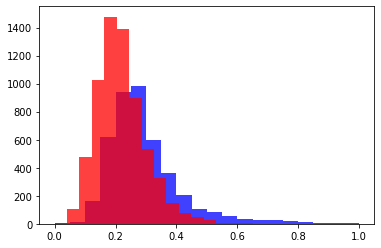

In [10]:
plt.figure()
plt.hist(dominant_top_rouge,20,color="b",alpha=0.75)
plt.hist(reference_top_rouge,20,color='r', alpha=0.75)
plt.show()

In [11]:
dominant_span_top_rouge = []
reference_span_top_rouge = []
for citing_data in tqdm(dataset):
    for span in citing_data["span_citation_mapping"]:
        span_text = citing_data["paragraph"][span["char_start"]: span["char_end"]]
        
        for Type, citations in span["span_citation_mapping"].items():
            for k,v in citations.items():
                span_text = span_text.replace(k, "")
        
        for citation_type, l in zip(["Dominant", "Reference"],[dominant_span_top_rouge, reference_span_top_rouge]):
            for k,v in span['span_citation_mapping'][citation_type].items():
                if v in dataset.cited_metadata and v in dataset.cited_paper:
                    cited_metadata = dataset.cited_metadata[v]
                    cited_paper = dataset.cited_paper[v]
                    sorted_cited_paper_sentences = retrieve_sentence_by_rouge(span_text, cited_metadata, cited_paper)
                    l.append(sorted_cited_paper_sentences[0][-1])

100%|██████████| 2927/2927 [24:23<00:00,  2.00it/s] 


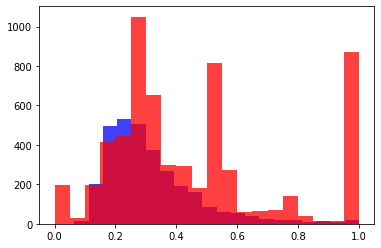

In [12]:
plt.figure()
plt.hist(dominant_span_top_rouge,20,color="b",alpha=0.75)
plt.hist(reference_span_top_rouge,20,color='r', alpha=0.75)
plt.show()

In [13]:
line_metric = np.mean

In [14]:
line_metric(dominant_top_rouge), line_metric(reference_top_rouge), line_metric(dominant_span_top_rouge), line_metric(reference_span_top_rouge)

(0.29259677540954765,
 0.21984365849469684,
 0.3155392836059902,
 0.4491081779999782)

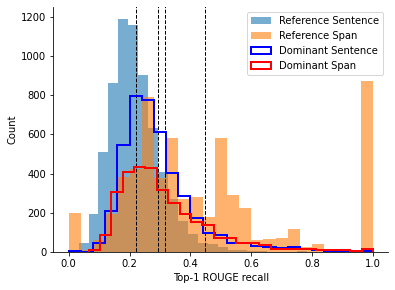

In [15]:
bins = 25
alpha = 0.6
fig, ax = plt.subplots(figsize=(6,4.5))
plt.hist(reference_top_rouge,bins, alpha=alpha, label="Reference Sentence")
plt.hist(reference_span_top_rouge,bins, alpha=alpha, label="Reference Span")
plt.hist(dominant_top_rouge,bins, histtype='step', color="b", alpha=1, linewidth=2, label="Dominant Sentence")
plt.hist(dominant_span_top_rouge,bins, histtype='step', color="r", linewidth=2, alpha=1, label="Dominant Span")

plt.vlines([line_metric(dominant_top_rouge)],-50, 1300, color="black", linewidth=1, linestyles="dashed")
plt.vlines([line_metric(reference_top_rouge)],-50, 1300, color="black", linewidth=1, linestyles="dashed")
plt.vlines([line_metric(dominant_span_top_rouge)],-50, 1300, color="black", linewidth=1, linestyles="dashed")
plt.vlines([line_metric(reference_span_top_rouge)],-50, 1300, color="black", linewidth=1, linestyles="dashed")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.ylim([0,1250])
plt.xlabel("Top-1 ROUGE recall")
plt.ylabel("Count")
#plt.title("Histogram of top-1 ROUGE recall")
plt.legend(loc="upper right")
#plt.show()
plt.savefig("ROUGE_retrieval.pdf",dpi=600,bbox_inches='tight')

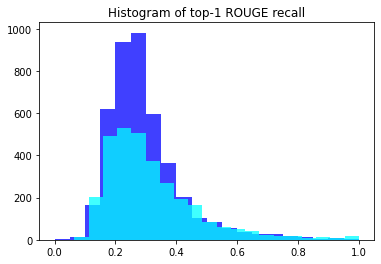

In [16]:
plt.figure()
plt.hist(dominant_top_rouge,20,color="b",alpha=0.75)
#plt.hist(reference_top_rouge,20,color='r', alpha=0.75)
plt.hist(dominant_span_top_rouge,20,color="cyan",alpha=0.75)
#plt.hist(reference_span_top_rouge,20,color='pink', alpha=0.75)
plt.title("Histogram of top-1 ROUGE recall")
plt.show()

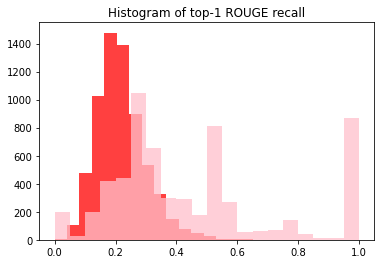

In [17]:
plt.figure()
#plt.hist(dominant_top_rouge,20,color="b",alpha=0.75)
plt.hist(reference_top_rouge,20,color='r', alpha=0.75)
#plt.hist(dominant_span_top_rouge,20,color="cyan",alpha=0.75)
plt.hist(reference_span_top_rouge,20,color='pink', alpha=0.75)
plt.title("Histogram of top-1 ROUGE recall")
plt.show()